<a href="https://colab.research.google.com/github/abhinav-exp/ELM_Implementaion/blob/main/Tao_ELM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)
print(data1)

            CBBTCUSD
DATE                
2017-06-18   2515.25
2017-06-19   2596.98
2017-06-20   2725.08
2017-06-21   2643.35
2017-06-22   2679.99
...              ...
2019-08-03  10820.75
2019-08-04  10997.82
2019-08-05  11775.14
2019-08-06  11440.08
2019-08-07  12014.41

[781 rows x 1 columns]


In [3]:
data1min = data1.min()
data1max = data1.max()

normalize = lambda x: (x - data1min + 1)/(data1max - data1min + 2)
data2 = normalize(data1)
print(data2)

            CBBTCUSD
DATE                
2017-06-18  0.034073
2017-06-19  0.038680
2017-06-20  0.045901
2017-06-21  0.041294
2017-06-22  0.043360
...              ...
2019-08-03  0.502247
2019-08-04  0.512228
2019-08-05  0.556045
2019-08-06  0.537158
2019-08-07  0.569532

[781 rows x 1 columns]


In [4]:
denormalize = lambda x: (x)*np.float64(data1max - data1min + 2) + np.float64(data1min - 1)

In [5]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x)
  return pd.DataFrame(X)

data3 = split_sequence(data2, 10)
print(data3.shape)
print(data3)

(771, 10)
            0         1         2         3         4         5         6  \
0    0.034073  0.038680  0.045901  0.041294  0.043360  0.043967  0.037432   
1    0.038680  0.045901  0.041294  0.043360  0.043967  0.037432  0.033530   
2    0.045901  0.041294  0.043360  0.043967  0.037432  0.033530  0.028023   
3    0.041294  0.043360  0.043967  0.037432  0.033530  0.028023  0.037484   
4    0.043360  0.043967  0.037432  0.033530  0.028023  0.037484  0.036208   
..        ...       ...       ...       ...       ...       ...       ...   
766  0.441959  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307   
767  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562   
768  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501   
769  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030   
770  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030  0.502247   

            7         8         9  
0    0.033530  0.028023  0.03

In [6]:
train_x = data3.iloc[:int(0.85*len(data3)), :-1]
train_y = data3.iloc[:int(0.85*len(data3)), -1:]
test_x = data3.iloc[int(0.85*len(data3)):, :-1]
test_y = data3.iloc[int(0.85*len(data3)):, -1:]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(655, 9)
(655, 1)
(116, 9)
(116, 1)


In [37]:
class TAO_ELM():
  def __init__(self, p_size):
    self.p_size = p_size
    self.no_hidden_nodes = 10
    self.weight = np.random.uniform(-0.5, 0.5, (self.p_size, 9, self.no_hidden_nodes))
    self.bias = np.random.uniform(0, 1, (self.p_size, self.no_hidden_nodes))
    self.beta = np.random.uniform(-0.5, 0.5, (self.p_size, self.no_hidden_nodes, 1))
    self.train_px = np.tile(np.expand_dims(train_x, axis = 0), (p_size, 1, 1))
    self.train_py = np.tile(np.expand_dims(train_y, axis = 0), (p_size, 1, 1))
    preds = self.forward_function(self.weight, self.bias, self.beta, self.train_px)
    error = (preds - self.train_py) ** 2
    self.mse = np.mean(error, axis = 1)
    self.supervisor = np.argmin(self.mse)
    self.best_error_graph = np.array([np.min(self.mse)])

  def sigmoid(self, x):
    return 1 / (1 + np.exp(-1 * x))

  def forward_function(self, weight, bias, beta, X):
    a = np.matmul(X, weight)
    c = np.expand_dims(bias, axis = len(bias.shape) - 1)
    b = a + c
    return self.sigmoid(np.matmul(b, beta))

  def forward_propagation(self, weight, bias, new_beta):
    preds = self.forward_function(weight, bias, new_beta, self.train_px)
    error = (preds - self.train_py) ** 2
    new_obj = np.mean(error, axis = 1)
    cond = (new_obj < self.mse)
    self.beta = np.where(np.expand_dims(cond, axis = 1), new_beta, self.beta)
    self.mse = np.where(cond, new_obj, self.mse)
    self.supervisor = np.argmin(self.mse)

  def optimise(self, gen):
    for i in range(gen):

      # supervisor guidance
      r = np.random.random((self.p_size, self.no_hidden_nodes, 1))
      I = np.round_(r)
      S = self.beta[self.supervisor]
      new_beta = self.beta + r * (S - I * self.beta)
      self.forward_propagation(self.weight, self.bias, new_beta)

      #information sharing
      cmp_better = self.mse.T >= self.mse
      cmp_better = np.expand_dims(cmp_better, axis = [2, 3])
      cnt_better = cmp_better.sum(axis = 1)

      SB = np.tile(np.expand_dims(self.beta, axis = 0), (self.p_size, 1, 1, 1))
      # print("SB", SB.shape)
      SB = np.where(cmp_better, SB, np.zeros(SB.shape))
      SB = SB.sum(axis = 1)/cnt_better

      preds = self.forward_function(self.weight, self.bias, SB, self.train_px)
      error = (preds - self.train_py) ** 2
      S_obj = np.mean(error, axis = 1)
      SGN = np.expand_dims(np.sign(self.mse - S_obj), axis = 2)

      r = np.random.random((self.p_size, self.no_hidden_nodes, 1))
      I = np.round_(r)
      beta = self.beta + r * (SB - I * self.beta) * SGN
      self.forward_propagation(self.weight, self.bias, beta)

      #individual activity
      r = np.random.random((self.p_size, self.no_hidden_nodes, 1))
      new_beta = self.beta + (-1*0.01 + r * 0.02) * self.beta
      self.forward_propagation(self.weight, self.bias, new_beta)

      # best error curve
      self.best_error_graph = np.append(self.best_error_graph, np.array([np.min(self.mse)]))



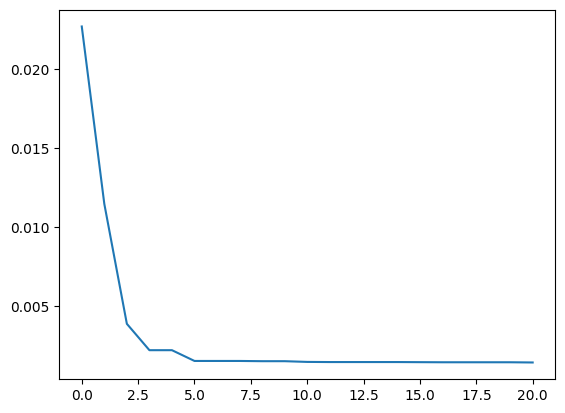

In [40]:
optimiser = TAO_ELM(1000)
optimiser.optimise(20)
ec = optimiser.best_error_graph
plt.plot(ec)
preds_train = optimiser.forward_function(optimiser.weight[optimiser.supervisor], optimiser.bias[optimiser.supervisor], optimiser.beta[optimiser.supervisor],  train_x)

In [41]:
print(preds_train.shape)
# print(np.array(train_y)[:, 0])
# print(np.array(preds_train)[:, 0])
error_train = (np.array(train_y)[:, 0] - np.array(preds_train)[:, 0])
# print(error_train)
print(np.mean((error_train) ** 2))

(655, 1)
0.0014256516661917875


In [42]:
preds = optimiser.forward_function(optimiser.weight[optimiser.supervisor], optimiser.bias[optimiser.supervisor], optimiser.beta[optimiser.supervisor], test_x)
print(preds.shape)
error_test = (np.array(test_y)[:, 0] - np.array(preds)[:, 0])
print(np.mean(error_test ** 2))

(116, 1)
0.0012762820483996104


In [43]:
np.array(preds)[:, 0]

array([0.18316749, 0.18302315, 0.1859387 , 0.18161874, 0.18799717,
       0.1878378 , 0.19281786, 0.19114459, 0.19606051, 0.19239169,
       0.19634155, 0.19891692, 0.20182173, 0.19417746, 0.18915125,
       0.18791174, 0.18579759, 0.18553183, 0.19049863, 0.19220399,
       0.19649396, 0.20236469, 0.21179746, 0.21315411, 0.21322055,
       0.21408846, 0.2167135 , 0.22604809, 0.23622452, 0.26228317,
       0.28384885, 0.30015007, 0.33107251, 0.34985602, 0.3340231 ,
       0.33420944, 0.29117735, 0.32283607, 0.3312632 , 0.33590658,
       0.33253253, 0.33536183, 0.32595727, 0.3448031 , 0.35342455,
       0.39323197, 0.38583945, 0.38888118, 0.37880257, 0.36031542,
       0.37514579, 0.37651309, 0.36368041, 0.34344571, 0.32183613,
       0.32939207, 0.32079571, 0.34076867, 0.32856359, 0.33201166,
       0.34077795, 0.33830007, 0.35006843, 0.37338843, 0.38129877,
       0.40647939, 0.4111225 , 0.42648966, 0.41555217, 0.43365121,
       0.45962592, 0.49074866, 0.52855553, 0.53744018, 0.57537

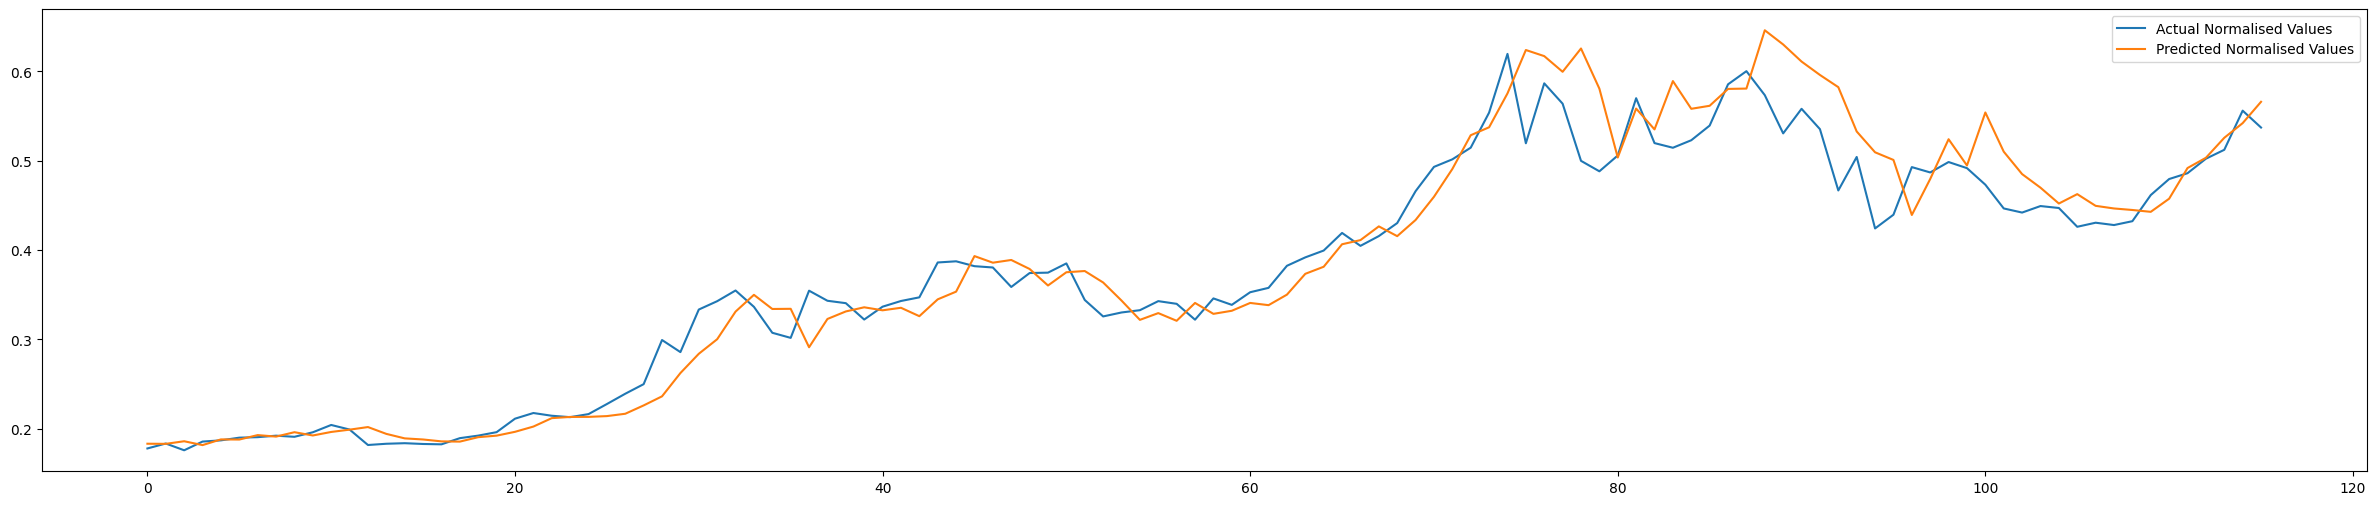

In [44]:
plt.figure(figsize=(30, 6))
plt.plot(test_y.reset_index()[9])
plt.plot(np.array(preds)[:, 0])
plt.legend(["Actual Normalised Values", "Predicted Normalised Values"])
plt.show()

In [45]:
denormalized_preds = denormalize(preds)
# print(denormalized_preds)
preds1 = pd.DataFrame(denormalized_preds)
preds1['DATE'] = data1.index[-1*len(preds1):]
preds1 = preds1.set_index('DATE')
print(preds1)

                       0
DATE                    
2019-04-14   5160.213398
2019-04-15   5157.652707
2019-04-16   5209.375242
2019-04-17   5132.738173
2019-04-18   5245.893034
...                  ...
2019-08-03  10635.605692
2019-08-04  10839.388534
2019-08-05  11236.344787
2019-08-06  11527.361009
2019-08-07  11951.224363

[116 rows x 1 columns]


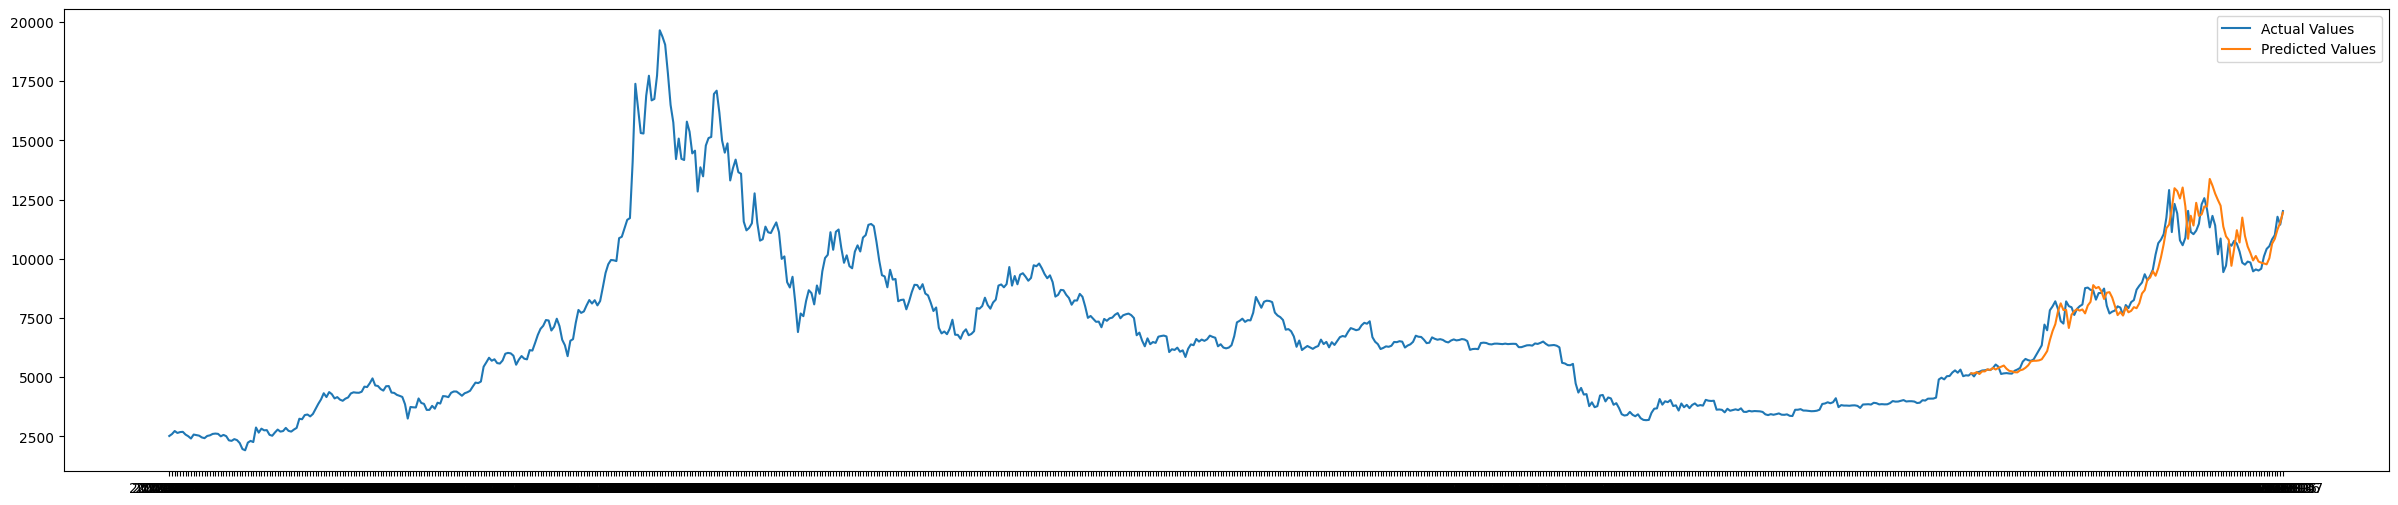

In [46]:
plt.figure(figsize=(30, 6))
plt.plot(data1)
plt.plot(preds1)
plt.legend(["Actual Values", "Predicted Values"])
plt.show()

In [47]:
mse = np.mean((np.array(preds1[0]) - np.array(data1.iloc[-1*(len(preds1)):, 0]))**2)
print("mse  "+ str(mse))
print("rmse "+ str(np.sqrt(mse)))

mse  573956.4326644908
rmse 757.5991239860899


In [48]:
(np.array(test_y) - np.array(preds))[:, 0]

array([-0.00529832,  0.00037301, -0.01011178,  0.00395496, -0.00106498,
        0.00210957, -0.00231413,  0.00102372, -0.00514642,  0.00359337,
        0.00782548,  0.00012898, -0.02008621, -0.01104962, -0.00539827,
       -0.00503812, -0.00330447,  0.00386312,  0.0017407 ,  0.00391691,
        0.01469947,  0.01517645,  0.0026913 , -0.00024142,  0.00310528,
        0.01350893,  0.02242151,  0.02379985,  0.06304837,  0.02345044,
        0.0495262 ,  0.04258168,  0.02363202, -0.01343535, -0.02664772,
       -0.03254368,  0.06334004,  0.02038158,  0.00925775, -0.01371797,
        0.00405838,  0.00759313,  0.02108615,  0.04128265,  0.03397009,
       -0.01129103, -0.00536411, -0.03021672, -0.00454587,  0.01438266,
        0.00987684, -0.03242342, -0.03800932, -0.01334119,  0.01081852,
        0.01341014,  0.01898906, -0.01872888,  0.01728029,  0.00662093,
        0.01199256,  0.01937398,  0.03229415,  0.01840751,  0.01814194,
        0.01266343, -0.00643722, -0.01086878,  0.01464631,  0.03

In [49]:
err_test = (np.array(test_y) - np.array(preds))[:, 0]
mse_test = np.mean(err_test ** 2)
rmse_test = np.sqrt(mse_test)
mae_test = np.mean(np.abs(err_test))
mape_test = np.mean(np.abs(err_test) / np.array(test_y)[:, 0])
EBPN = pd.DataFrame([[mse_test, rmse_test, mae_test, mape_test]], columns = ["mse", "rmse", "mae", "mape"], index = ['BPN'])
EBPN

,mse,rmse,mae,mape
BPN,0.001276,0.035725,0.024724,0.061236
